# Problema de Negócio:

* Uma empresa de energia solar quer entender o impacto das condições meteorológicas na geração de energia solar. O objetivo é desenvolver um modelo que possa prever a Irradiância Global Horizontal (GHI) com base na umidade relativa do ar e na temperatura ambiente. Isso ajudará a empresa a otimizar a eficiência dos painéis solares em diferentes condições climáticas.

# Descrição das variáveis:

* TS: Timestamp (data e hora da medição).
* RH: Umidade relativa do ar (%).
* TAMB: Temperatura ambiente (°C).
* GHI: Irradiância global horizontal (W/m²).

# Importação das bibliotecas necessárias:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
from sklearn.metrics import(
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from prophet import Prophet

# Tratamento inicial dos dados:

In [2]:
# Carregamento da base de dados:
df = pd.read_csv('weather_data.csv')

# Transfomando a coluna de datas para o formato datetime:
df['TS'] = pd.to_datetime(df['TS'])

# Criando uma variável para os registros mensais:
df_meses = df.copy()
df_meses.set_index('TS', inplace=True)
df_meses = df_meses.resample('M').mean()

# Criando uma variável para os registros diários:
df_dias = df.copy()
df_dias.set_index('TS', inplace=True)
df_dias = df_dias.resample('D').mean()

# Colocando a variável de data como indice do dataframe:
df.set_index('TS', inplace=True)

df

/tmp/ipykernel_23233/920513566.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_meses = df_meses.resample('M').mean()


,RH,TAMB,GHI
TS,,,
2024-04-10 00:00:00,95.199997,24.900000,-1.0
2024-04-10 00:01:00,95.000000,24.900000,-1.0
2024-04-10 00:02:00,95.000000,24.900000,-0.5
2024-04-10 00:03:00,95.099998,24.900000,-0.5
2024-04-10 00:04:00,95.500000,24.900000,-0.5
...,...,...,...
2024-10-14 21:21:00,85.900002,23.799999,-0.5
2024-10-14 21:22:00,85.900002,23.799999,-0.5
2024-10-14 21:23:00,86.099998,23.799999,-0.5


In [3]:
df_meses

,RH,TAMB,GHI
TS,,,
2024-04-30,89.434531,26.138483,172.665590
2024-05-31,87.293172,26.499536,191.091011
2024-06-30,84.662574,26.018147,221.243582
2024-07-31,73.553466,22.438278,196.695653
2024-08-31,71.869000,26.003777,262.255236
2024-09-30,67.606602,26.906787,275.334120
2024-10-31,70.799100,26.998220,272.110622


In [4]:
df_dias

,RH,TAMB,GHI
TS,,,
2024-04-10,89.567144,26.355476,159.156764
2024-04-11,89.512089,26.349825,163.468903
2024-04-12,88.047847,26.706389,240.848264
2024-04-13,90.931579,26.293985,178.477026
2024-04-14,NaN,NaN,NaN
...,...,...,...
2024-10-10,76.231111,26.422014,266.469792
2024-10-11,67.418403,27.432917,296.277778
2024-10-12,66.448472,27.654097,263.389931


In [5]:
# O df_dias apresenta valores nan, para tratar isso, vamos usar o método interpolate:
df_dias = df_dias.interpolate(method='time')
df_dias

,RH,TAMB,GHI
TS,,,
2024-04-10,89.567144,26.355476,159.156764
2024-04-11,89.512089,26.349825,163.468903
2024-04-12,88.047847,26.706389,240.848264
2024-04-13,90.931579,26.293985,178.477026
2024-04-14,91.332875,26.121642,162.104358
...,...,...,...
2024-10-10,76.231111,26.422014,266.469792
2024-10-11,67.418403,27.432917,296.277778
2024-10-12,66.448472,27.654097,263.389931


* Verificando os tipos de dados e se há valores ausentes:

In [6]:
df_meses.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7 entries, 2024-04-30 to 2024-10-31
Freq: ME
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RH      7 non-null      float64
 1   TAMB    7 non-null      float64
 2   GHI     7 non-null      float64
dtypes: float64(3)
memory usage: 224.0 bytes


In [7]:
df_dias.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 188 entries, 2024-04-10 to 2024-10-14
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RH      188 non-null    float64
 1   TAMB    188 non-null    float64
 2   GHI     188 non-null    float64
dtypes: float64(3)
memory usage: 5.9 KB


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 224783 entries, 2024-04-10 00:00:00 to 2024-10-14 21:25:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   RH      224783 non-null  float64
 1   TAMB    224783 non-null  float64
 2   GHI     224783 non-null  float64
dtypes: float64(3)
memory usage: 6.9 MB


# Descrição dos dataframes:

* Nesta etapa, analisamos estatísticas descritivas das variáveis RH, TAMB e GHI nos dataframes original (`df`), mensal (`df_meses`) e diário (`df_dias`) para identificar padrões, tendências e possíveis inconsistências nos dados.


In [9]:
df.describe()

,RH,TAMB,GHI
count,224783.000000,224783.000000,224783.000000
mean,76.238337,25.679468,233.720984
std,18.038884,4.793512,331.019706
min,30.900000,2.200000,-20.000000
25%,62.599998,23.299999,-0.500000
50%,80.199997,25.100000,0.500000
75%,93.000000,29.200001,432.500000
max,499.899994,465.100006,1417.500000


* No dataframe original, observamos que a variável **RH (umidade relativa)** apresenta valores superiores a 100%, o que é fisicamente impossível. Já a **TAMB (temperatura ambiente)** tem valores mínimos de até 2°C e valores maximos de quase 500°C, o que não condiz com o clima do Nordeste brasileiro.

In [10]:
df_meses.describe()

,RH,TAMB,GHI
count,7.000000,7.000000,7.000000
mean,77.888349,25.857604,227.342259
std,8.931692,1.561607,42.439055
min,67.606602,22.438278,172.665590
25%,71.334050,26.010962,193.893332
50%,73.553466,26.138483,221.243582
75%,85.977873,26.703162,267.182929
max,89.434531,26.998220,275.334120


* Ao analisar os dados agregados mensalmente (`df_mensal`), percebemos que os valores extremos são suavizados, mas ainda podem refletir outliers presentes nos dados originais.

In [11]:
df_dias.describe()

,RH,TAMB,GHI
count,188.000000,188.000000,188.000000
mean,78.059595,25.543770,218.706053
std,9.328714,3.410906,75.834016
min,55.903403,5.617153,0.000000
25%,70.245816,25.603651,186.292757
50%,77.810538,26.115278,243.795486
75%,85.247388,26.893507,271.514583
max,98.375260,27.837430,341.886188


* No dataframe diário (`df_diario`), apesar de uma média e mediana mais realistas, identificamos uma temperatura mínima de 5,6°C — ainda muito improvável para a região. Isso reforça a necessidade de um tratamento de outliers antes de aplicar modelos preditivos.

* Vamos visualizar os outliers de cada variável com um boxplot:

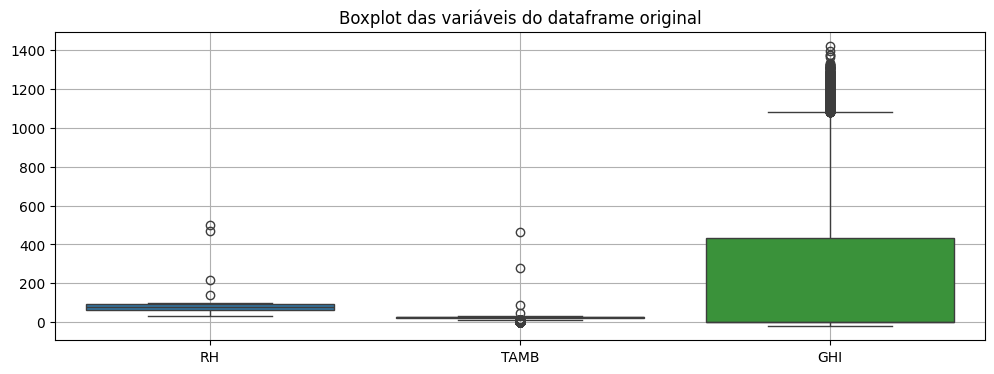

In [12]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df[['RH', 'TAMB', 'GHI']])
plt.title('Boxplot das variáveis do dataframe original')
plt.grid()
plt.show()

* No boxplot acima podemos observar em cada variável os outliers que estão muito no extremo.
    1. Na variável RH podemos perceber que temos valores concentrados em uma faixa razoável, mas também podemos perceber valores extremos, que passam dos 100%, o que é fisicamente impossivel, percebemos também valores próximos da mediana.
    2. Na variável TAMB os valores estão concentrados em uma faixa estreita, mas tambem podemos observar valores extremos, que chegam em uma temperatura improvável para o nordeste. Na temperatura ambiente também podemos observar valores próximos a mediana.
    3. A variável GHI apresenta uma distribuição ampla de valores, com outiers significativos. Os valores da irradiação estão espalhados, com uma grande variabilidade. 

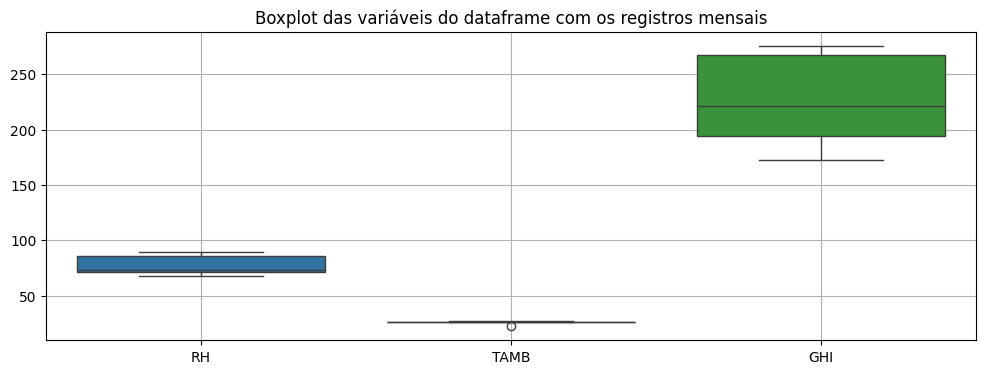

In [13]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df_meses[['RH', 'TAMB', 'GHI']])
plt.title('Boxplot das variáveis do dataframe com os registros mensais')
plt.grid()
plt.show()

* Acima podemos perceber que:
1. Os valores de RH estão concentrados em uma faixa razoável, com poucos outliers. A mediana está próxima do centro da caixa, indicando uma distribuição relativamente simétrica.
2. Os valores de TAMB estão concentrados em uma faixa estreita, com alguns outliers. A mediana está próxima do limite inferior da caixa, sugerindo uma leve assimetria na distribuição.
3. O GHI apresenta uma ampla distribuição de valores, com uma maior variabilidade em comparação às outras variáveis. A mediana está deslocada para o limite inferior da caixa, indicando uma distribuição assimétrica.

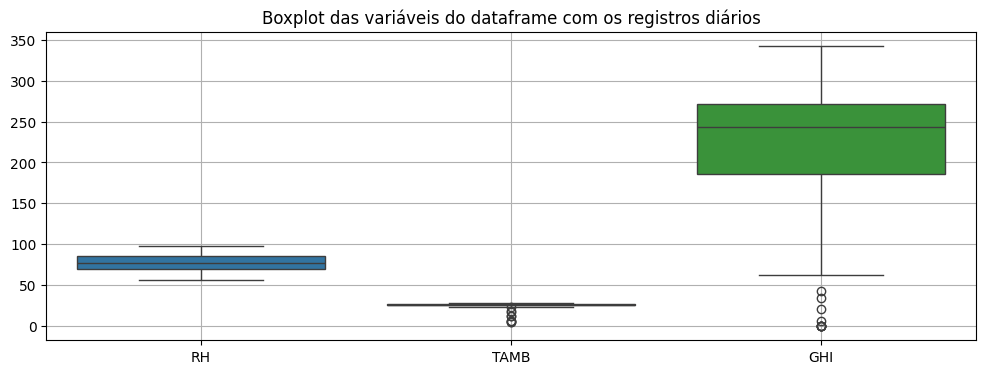

In [14]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df_dias[['RH', 'TAMB', 'GHI']])
plt.title('Boxplot das variáveis do dataframe com os registros diários')
plt.grid()
plt.show()

* No dataframe que contém os registros diários podemos perceber:
1. A maioria dos valores está concentrada em uma faixa razoável, com poucos outliers. A mediana está próxima do centro da caixa, indicando uma distribuição relativamente simétrica. Há valores extremos acima de 100%, o que é fisicamente impossível e precisa ser tratado.
2. Os valores estão concentrados em uma faixa estreita, mas há outliers significativos. A mediana está próxima do limite inferior da caixa, sugerindo uma leve assimetria na distribuição. Alguns valores extremos são improváveis para a região analisada.
3. Apresenta uma ampla distribuição de valores, com uma grande variabilidade. Há muitos outliers, indicando que a variável possui valores extremos significativos. A mediana está deslocada para o limite inferior da caixa, sugerindo uma distribuição assimétrica.

# Tratamento de outliers:

In [15]:
# Sabemos que os limites da umidade relativa é de 0% a 100%, portanto: 
limite_inferior_RH = 0
limite_superior_RH = 100
outliers_RH = (df['RH'] < limite_inferior_RH) | (df['RH'] > limite_superior_RH)

In [16]:
# Agora vamos tratar os outliers da temperatura ambiente. 
# O aceitável é uma temperatura ambiente entre 20°C e um pouco mais de 30°C.
IQR_TAMB = df['TAMB'].quantile(0.75) - df['TAMB'].quantile(0.25)
limite_inferior_TAMB = df['TAMB'].quantile(0.05) # 95% dos dados estão acima desse quartil 
limite_superior_TAMB = df['TAMB'].quantile(0.75) + (1.5 * IQR_TAMB)
outliers_TAMB = (df['TAMB'] <= limite_inferior_TAMB) | (df['TAMB'] >= limite_superior_TAMB)
limite_inferior_TAMB, limite_superior_TAMB

(20.700000762939453, 38.05000305175781)

In [17]:
# Agora vamos tratar os outliers da radiação solar global (GHI).
# O valor minimo aceitável é 0 e o máximo aceitável é 1000 W/m², ou até um pouco mais que isso.
IQR_GHI = df['GHI'].quantile(0.75) - df['GHI'].quantile(0.25)
limite_inferior_GHI = 0 
limite_superior_GHI = df['GHI'].quantile(0.75) + (1.5 * IQR_GHI)
outliers_GHI = (df['GHI'] <= limite_inferior_GHI) | (df['GHI'] >= limite_superior_GHI)
limite_inferior_GHI, limite_superior_GHI

(0, 1082.0)

In [18]:
# Dataframe filtrado:
outliers = (outliers_RH | outliers_TAMB | outliers_GHI)
df_limpo = df[~outliers]
df_limpo

,RH,TAMB,GHI
TS,,,
2024-04-10 00:32:00,95.000000,24.799999,0.5
2024-04-10 00:33:00,95.000000,24.799999,0.5
2024-04-10 00:34:00,95.000000,24.799999,0.5
2024-04-10 00:35:00,95.099998,24.799999,0.5
2024-04-10 00:36:00,95.300003,24.799999,0.5
...,...,...,...
2024-10-14 17:39:00,73.900002,25.900000,1.0
2024-10-14 17:40:00,73.900002,25.900000,0.5
2024-10-14 17:41:00,74.000000,25.799999,0.5


* Agora que o DataFrame central já foi tratado, podemos apenas copiar e agrupar os dados médios mensais e diarios.

In [19]:
df_mensal = df_limpo.copy()
df_mensal = df_mensal.resample('M').mean()

df_diario = df_limpo.copy()
df_diario = df_diario.resample('D').mean()
df_diario = df_diario.interpolate(method='time')

/tmp/ipykernel_23233/2662954126.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensal = df_mensal.resample('M').mean()


* Agora com os dados já tratados de outliers, vamos ver a descrição dos dataframes: 

In [20]:
df_limpo.describe()

,RH,TAMB,GHI
count,113104.000000,113104.000000,113104.000000
mean,65.690337,28.563681,444.271012
std,16.894269,2.965152,324.844208
min,30.900000,20.799999,0.500000
25%,51.599998,26.500000,146.000000
50%,64.800003,29.100000,409.000000
75%,78.000000,30.900000,734.500000
max,99.599998,34.700001,1081.500000


In [21]:
df_mensal.describe()

,RH,TAMB,GHI
count,7.000000,7.000000,7.000000
mean,67.840433,28.485540,426.762934
std,11.926375,0.673331,81.647355
min,55.860034,27.398206,288.213267
25%,58.542521,28.180391,381.020654
50%,61.712436,28.287843,470.651466
75%,77.789780,29.033779,481.028151
max,84.645961,29.284394,504.378195


In [22]:
df_diario.describe()

,RH,TAMB,GHI
count,188.000000,188.000000,188.000000
mean,68.091740,28.381697,413.602946
std,12.325818,1.096536,119.424969
min,47.030252,23.940769,23.953846
25%,57.689506,28.052482,353.715522
50%,66.308748,28.665815,445.748509
75%,76.856109,29.067428,500.946044
max,97.655385,30.081103,598.833568


* Vamos visualizar novavamente os boxplots de cada dataframe:

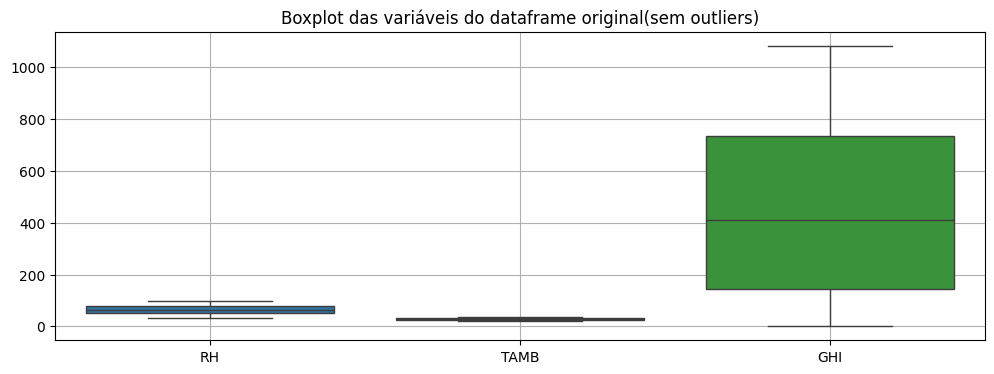

In [23]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df_limpo[['RH', 'TAMB', 'GHI']])
plt.title('Boxplot das variáveis do dataframe original(sem outliers)')
plt.grid()
plt.show()

* No gráfico de boxplot acima podemos observar:
1. **RH (Umidade Relativa)**:
    - Os valores estão concentrados em uma faixa estreita, com a mediana próxima ao centro da caixa, indicando uma distribuição relativamente simétrica.
    - Não há valores extremos visíveis, o que confirma que os outliers foram removidos.

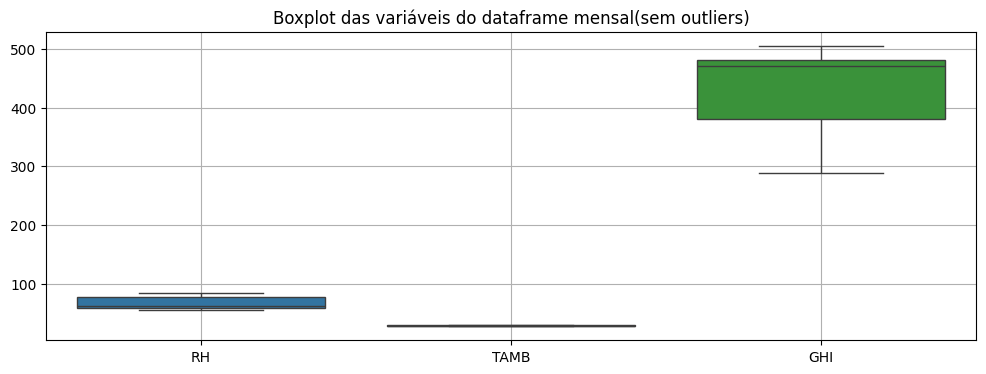

In [24]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df_mensal[['RH', 'TAMB', 'GHI']])
plt.title('Boxplot das variáveis do dataframe mensal(sem outliers)')
plt.grid()
plt.show()

No gráfico de boxplot acima podemos observar:
1. **RH (Umidade Relativa)**:
    - Os valores estão concentrados em uma faixa razoável, com poucos outliers visíveis.
    - A mediana está próxima do centro da caixa, indicando uma distribuição relativamente simétrica.

2. **TAMB (Temperatura Ambiente)**:
    - Os valores estão concentrados em uma faixa estreita, com poucos outliers.
    - A mediana está próxima do limite inferior da caixa, sugerindo uma leve assimetria na distribuição.

3. **GHI (Irradiância Global Horizontal)**:
    - Apresenta uma ampla distribuição de valores, com maior variabilidade em comparação às outras variáveis.
    - A mediana está deslocada para o limite inferior da caixa, indicando uma distribuição assimétrica.

Esses padrões confirmam que o tratamento de outliers foi eficaz, mas a variabilidade natural das variáveis foi preservada.

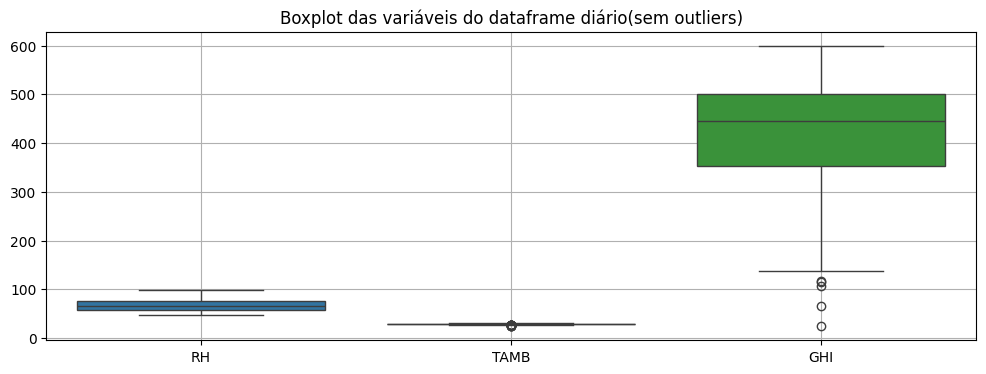

In [25]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df_diario[['RH', 'TAMB', 'GHI']])
plt.title('Boxplot das variáveis do dataframe diário(sem outliers)')
plt.grid()
plt.show()

### Justificativa para a Manutenção de Valores Baixos de GHI no DataFrame Diário

Durante a análise do `df_diario`, identificamos valores de Irradiância Global Horizontal (GHI) com média diária tão baixa quanto aproximadamente 23 W/m². Em um primeiro momento, esses valores podem parecer outliers estatísticos ao visualizarmos o boxplot, especialmente quando comparados à média geral da região.

No entanto, de acordo com dados da ABSOLAR, a irradiação solar média no Nordeste do Brasil é de aproximadamente 5,5 kWh/m².dia, o que equivale a cerca de 230 W/m² em termos de irradiância média ao longo do dia. Esse valor representa uma média **anual** e **regional** — não um valor mínimo físico para qualquer dia.

É importante destacar que a irradiância solar **varia naturalmente ao longo do tempo**, sendo nula durante a noite, mais intensa ao meio-dia e bastante reduzida em dias nublados ou chuvosos. Portanto, dias com média de 20–100 W/m² podem ocorrer em condições climáticas adversas e são esperados em uma série temporal meteorológica real.

Com base nisso, optamos por **não tratar como outliers valores baixos de GHI no `df_diario`**, pois eles representam a variabilidade natural da radiação solar e são informações valiosas para o modelo preditivo. Remover esses dados poderia reduzir a capacidade do modelo de prever situações de baixa geração solar — o que vai contra o objetivo do projeto.


# Distribuição dos dados:

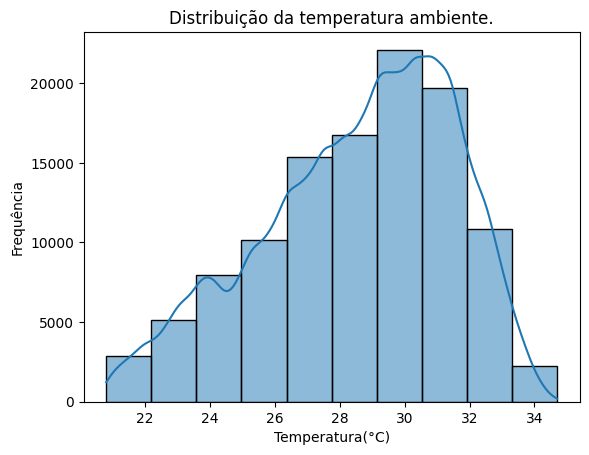

In [26]:
# Distribuição dos dados de TAMB:
sns.histplot(df_limpo['TAMB'], bins=10, kde=True)
plt.title('Distribuição da temperatura ambiente.')
plt.xlabel('Temperatura(°C)')
plt.ylabel('Frequência')
plt.show()

* Na distribuição dos dados de temperatura podemos observar:

1. Forma da Distribuição: A distribuição parece ser aproximadamente simétrica, com um leve viés à direita.
2. Pico da Distribuição: O pico ocorre em torno de 30°C, indicando que essa é a temperatura mais frequente.
3. Amplitude: Os valores variam aproximadamente entre 22°C e 34°C.
4. Curva de Densidade: A curva suaviza as oscilações do histograma, ajudando a identificar a tendência geral da distribuição.

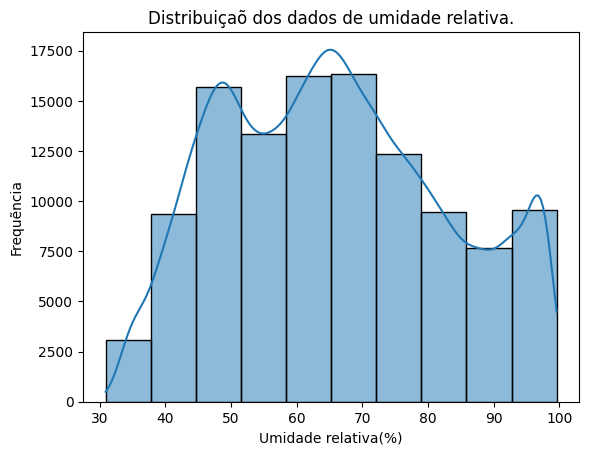

In [27]:
# Distribuição dos dados de RH:
sns.histplot(df_limpo['RH'], kde=True, bins=10)
plt.title('Distribuiçaõ dos dados de umidade relativa.')
plt.xlabel('Umidade relativa(%)')
plt.ylabel('Frequẽncia')
plt.show()

* Na distribuição dos dados de umidade relativa podemos observar:

1. **Forma da Distribuição**: A curva de densidade sugere que a distribuição é multimodal, com picos em torno de 50% e 70%.
2. **Assimetria**: A distribuição parece levemente assimétrica, com uma cauda mais longa em direção a valores mais altos.
3. **Frequência**: A maior frequência ocorre entre 50% e 70%, indicando que a maioria dos dados de umidade relativa está concentrada nesse intervalo.


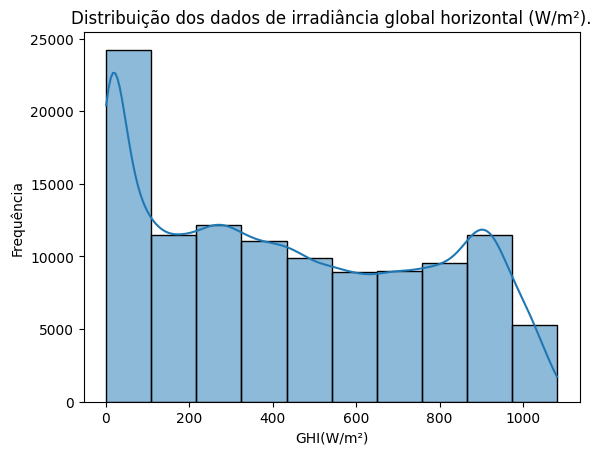

In [28]:
# Distribuição dos de GHI:
sns.histplot(df_limpo['GHI'], kde=True, bins=10)
plt.title('Distribuição dos dados de irradiância global horizontal (W/m²).')
plt.xlabel('GHI(W/m²)')
plt.ylabel('Frequência')
plt.show()

* Na distribuição dos dados de irrâdiancia podemos observar:

1. **Distribuição Assimétrica**: A distribuição parece ser assimétrica à direita, com uma concentração maior de valores em torno de 0 a 200 W/m² e uma cauda longa em direção a valores mais altos.

2. **Presença de Pico Inicial**: Existe um pico inicial significativo, indicando que a maioria dos valores de GHI está em níveis baixos.

3. **KDE (Kernel Density Estimation)**: A linha azul representa a estimativa de densidade kernel (KDE), que suaviza a distribuição para mostrar a tendência geral dos dados.

4. **Valores Extremos**: A cauda direita sugere a presença de valores extremos em níveis mais altos de GHI.


# Analise de sazonalidade de GHI:

In [29]:
import matplotlib.dates as mdates

In [30]:
# Como pretendemos plotar series temporais, vamos criar uma função para isso:
def plot_ghi(df_diario, mes, nome_mes):
    df_mes = df_diario[df_diario.index.month == mes]
    fig, ax = plt.subplots(figsize=(12,4))
    plt.suptitle(f'Comportamento diário da irradiância global horizontal - {nome_mes}', fontsize=16)
    ax.plot(df_mes['GHI'], marker='o', linestyle='--', label=f'GHI - {nome_mes}')
    ax.set_xlabel('Dias')
    ax.set_ylabel('Geração de GHI (W/m²)')
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.show()

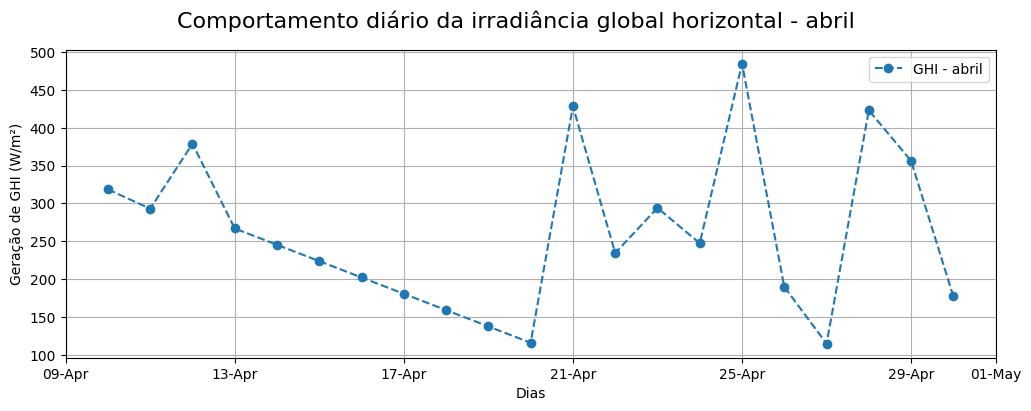

In [31]:
# Vamos plotar a série temporal da irradiância global horizontal para o mês de abril:
plot_ghi(df_diario, 4, 'abril')

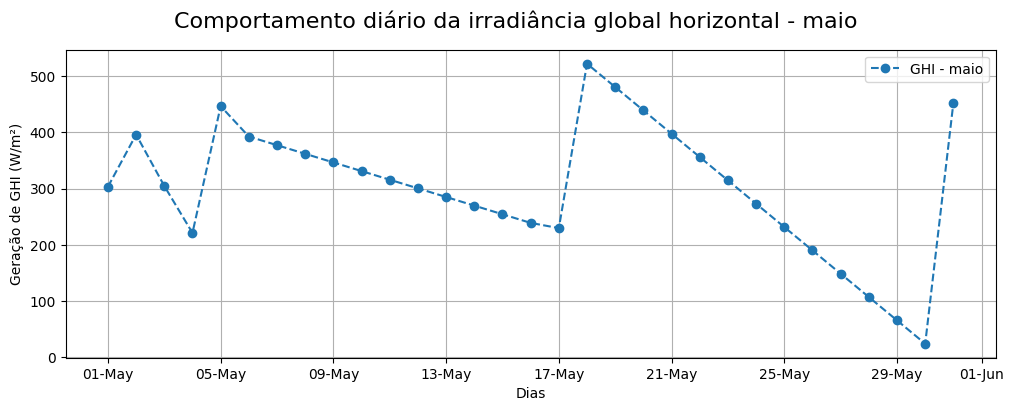

In [32]:
# Plotando o comportamento diário da irradiância global horizontal para o mês de maio:
plot_ghi(df_diario, 5, 'maio')

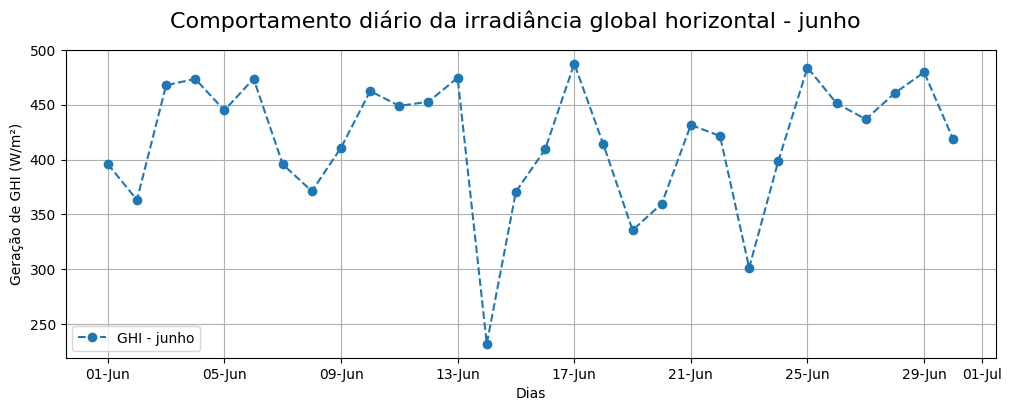

In [33]:
# Plotando o comportamento diário da irradiância global horizontal para o mês de junho:
plot_ghi(df_diario, 6, 'junho')

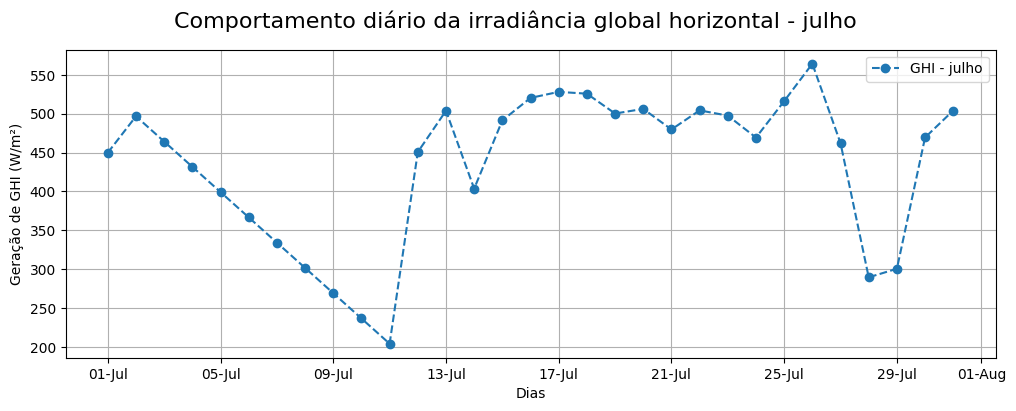

In [34]:
# Plotando o comportamento diário da irradiância global horizontal para o mês de julho:
plot_ghi(df_diario, 7, 'julho')

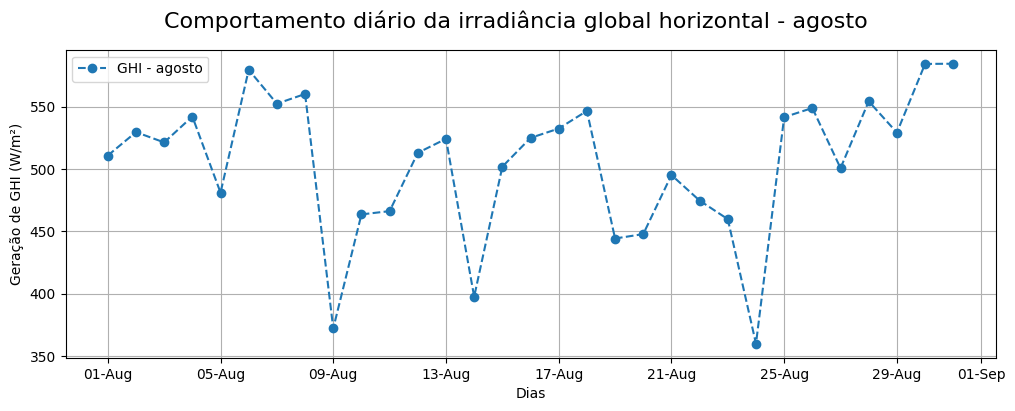

In [35]:
# Plotando o comportamento diário da irradiância global horizontal para o mês de agosto:
plot_ghi(df_diario, 8, 'agosto')

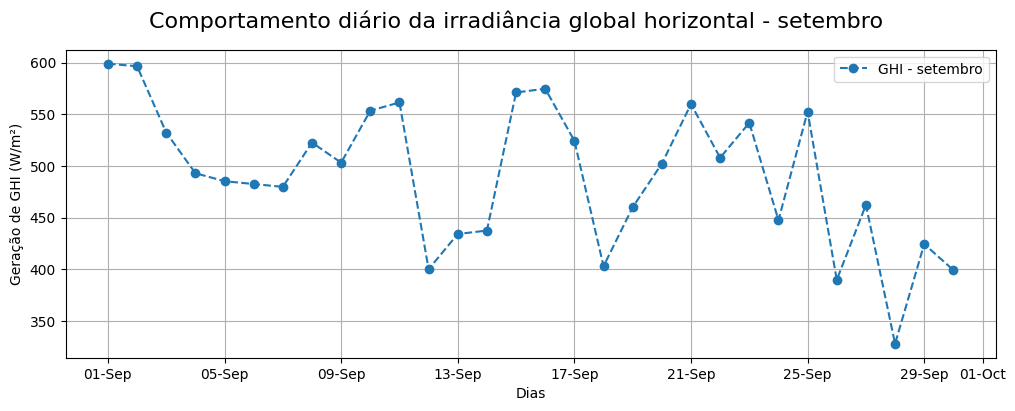

In [36]:
# Plotando o comportamento diário da irradiância global horizontal para o mês de setembro:
plot_ghi(df_diario, 9, 'setembro')

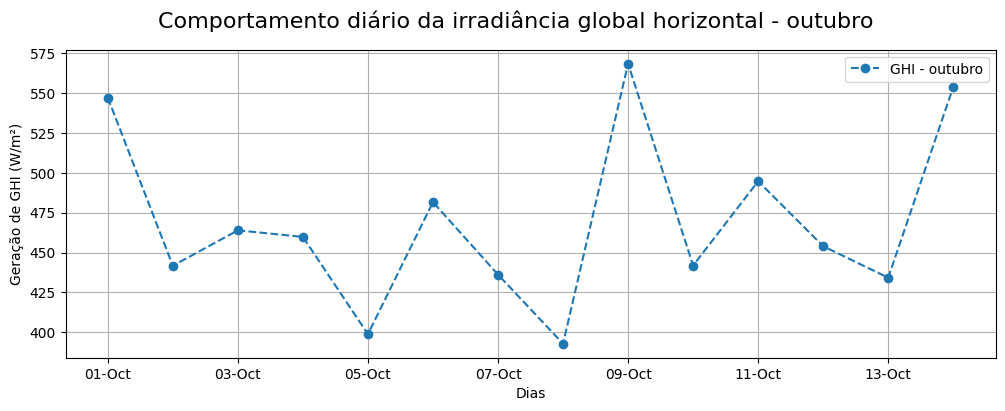

In [37]:
# Plotando o comportamento diário da irradiância global horizontal para o mês de outubro:
plot_ghi(df_diario, 10, 'outubro')

1. **Padrão Geral**:
    - A análise dos gráficos de séries temporais meteorológicas revelou padrões importantes na variabilidade diária e sazonal das variáveis analisadas, especialmente a irradiância global horizontal (GHI). 
        - Observamos que o GHI apresenta uma alta variabilidade diária, com picos e vales bem definidos, refletindo a influência de fatores climáticos como cobertura de nuvens, duração do dia e condições atmosféricas.
        - A temperatura ambiente (TAMB) mostrou uma distribuição mais estável ao longo do tempo, com variações menores, mas ainda assim influenciada por padrões sazonais e diários.
        - A umidade relativa (RH) apresentou flutuações moderadas, com valores mais altos em períodos de maior cobertura de nuvens e condições climáticas adversas.

    2. **Tendências Sazonais**:
        - A análise sazonal destacou um aumento gradual na irradiância solar ao longo dos meses, especialmente nos meses de inverno e primavera, indicando condições climáticas mais favoráveis para a geração de energia solar.
        - A temperatura ambiente também apresentou uma leve tendência de aumento ao longo do período analisado, enquanto a umidade relativa mostrou uma tendência de redução, possivelmente associada a períodos mais secos.

    3. **Implicações para o Negócio**:
        - A variabilidade observada no GHI é crucial para o planejamento da geração de energia solar, pois dias com baixa irradiância podem impactar negativamente a produção, enquanto dias com alta irradiância representam oportunidades para maximizar a eficiência dos painéis solares.
        - A análise sazonal pode ser utilizada para prever períodos de maior ou menor geração de energia, auxiliando na otimização de estratégias de armazenamento e distribuição.

    4. **Recomendações**:
        - Incorporar as tendências e variabilidades observadas nos modelos preditivos para melhorar a precisão das previsões de geração de energia solar.
        - Monitorar continuamente as condições climáticas e ajustar os modelos conforme necessário para capturar mudanças sazonais e anomalias.
        - Utilizar os dados para desenvolver estratégias de mitigação para períodos de baixa geração, como o uso de sistemas de armazenamento de energia ou fontes complementares.


# Médias móveis:

In [38]:
# Janela de 3 meses para suavizar os dados no dataframe mensal:
df_mensal['GHI_mm3'] = df_mensal['GHI'].rolling(window=3,min_periods=1).mean()
df_mensal['TAMB_mm3'] = df_mensal['TAMB'].rolling(window=3, min_periods=1).mean()
df_mensal['RH_mm3'] = df_mensal['RH'].rolling(window=3, min_periods=1).mean()

# Janela de 7 dias (média móvel semanal):
df_diario['GHI_mm7'] = df_diario['GHI'].rolling(window=7, min_periods=1).mean()
df_diario['TAMB_mm7'] = df_diario['TAMB'].rolling(window=7, min_periods=1).mean()
df_diario['RH_mm7'] = df_diario['RH'].rolling(window=7, min_periods=1).mean()

# Janela de 30 dias (média móvel mensal):
df_diario['GHI_mm30'] = df_diario['GHI'].rolling(window=30, min_periods=1).mean()
df_diario['TAMB_mm30'] = df_diario['TAMB'].rolling(window=30, min_periods=1).mean()
df_diario['RH_mm30'] = df_diario['RH'].rolling(window=30, min_periods=1).mean()

* Agora vamos plotar três gráficos para vermos como a média móvel se comportou nas variáveis: RH, TAMB e GHI em uma janela de três meses:

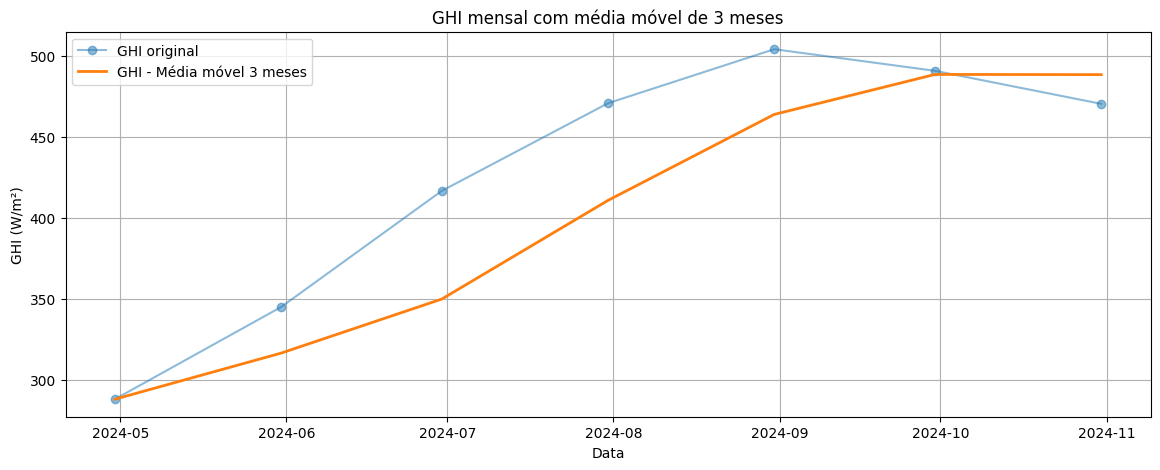

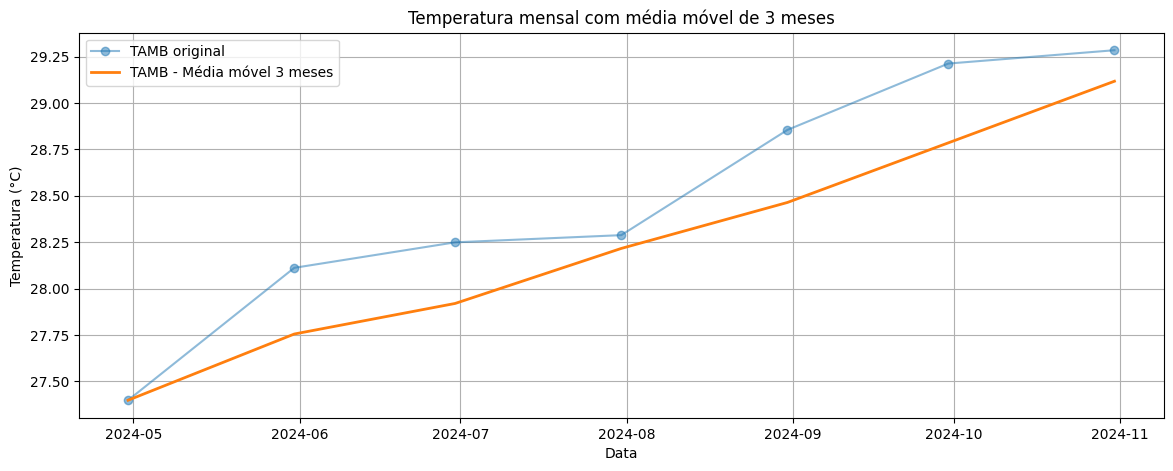

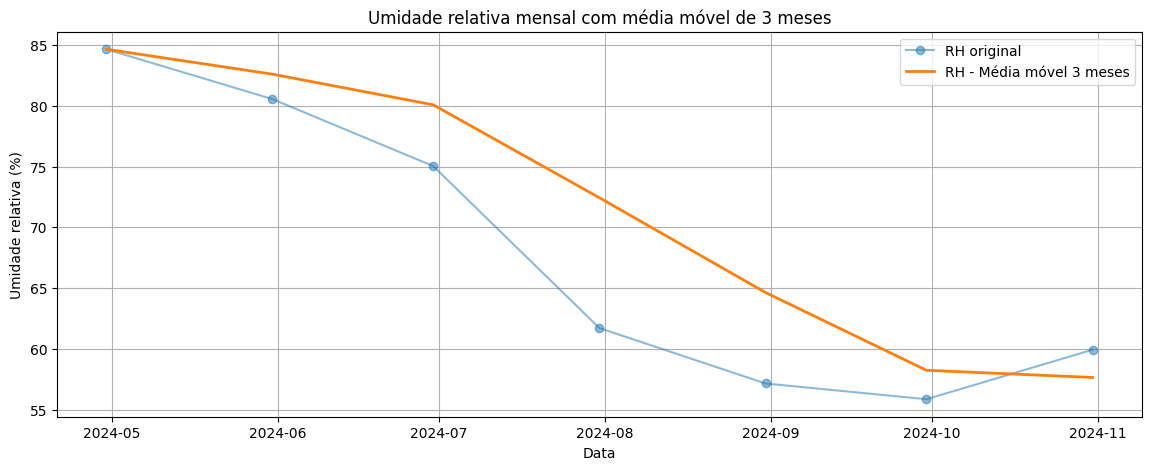

In [39]:
plt.figure(figsize=(14, 5))
plt.plot(df_mensal['GHI'], label='GHI original', marker='o', alpha=0.5)
plt.plot(df_mensal['GHI_mm3'], label='GHI - Média móvel 3 meses', linewidth=2)
plt.title('GHI mensal com média móvel de 3 meses')
plt.xlabel('Data')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_mensal['TAMB'], label='TAMB original', marker='o', alpha=0.5)
plt.plot(df_mensal['TAMB_mm3'], label='TAMB - Média móvel 3 meses', linewidth=2)
plt.title('Temperatura mensal com média móvel de 3 meses')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_mensal['RH'], label='RH original', marker='o', alpha=0.5)
plt.plot(df_mensal['RH_mm3'], label='RH - Média móvel 3 meses', linewidth=2)
plt.title('Umidade relativa mensal com média móvel de 3 meses')
plt.xlabel('Data')
plt.ylabel('Umidade relativa (%)')
plt.legend()
plt.grid()
plt.show()

* Agora vamos ver como as médias móveis, em uma janela de 7 dias, se comportou:

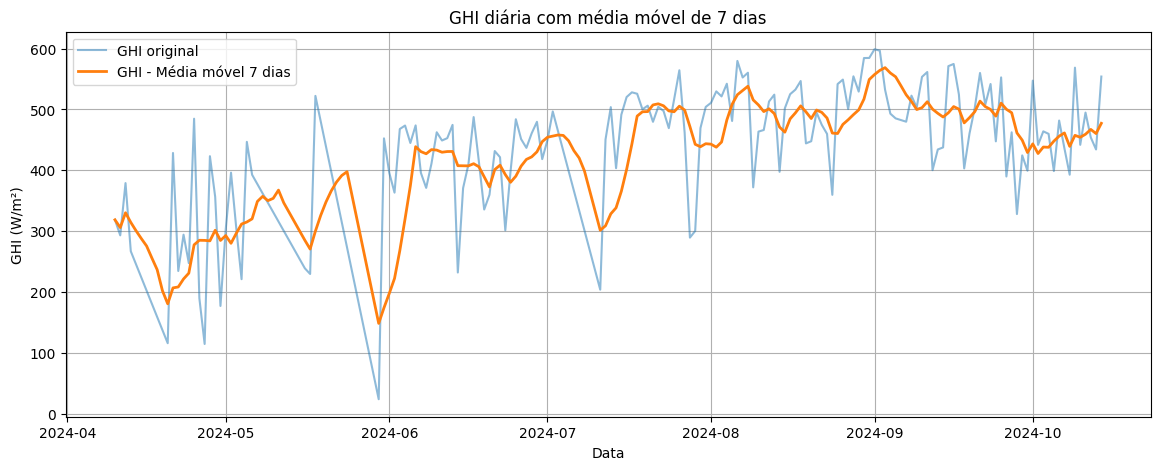

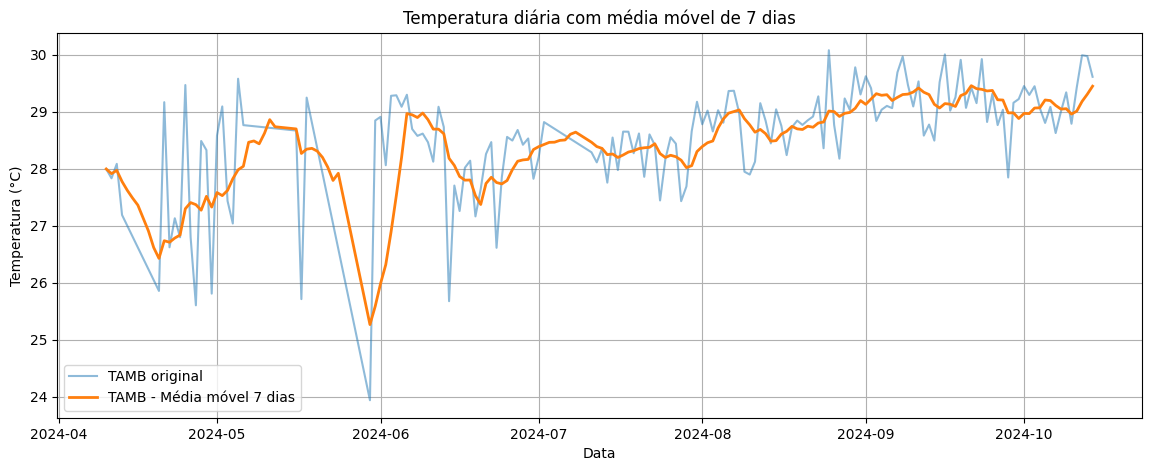

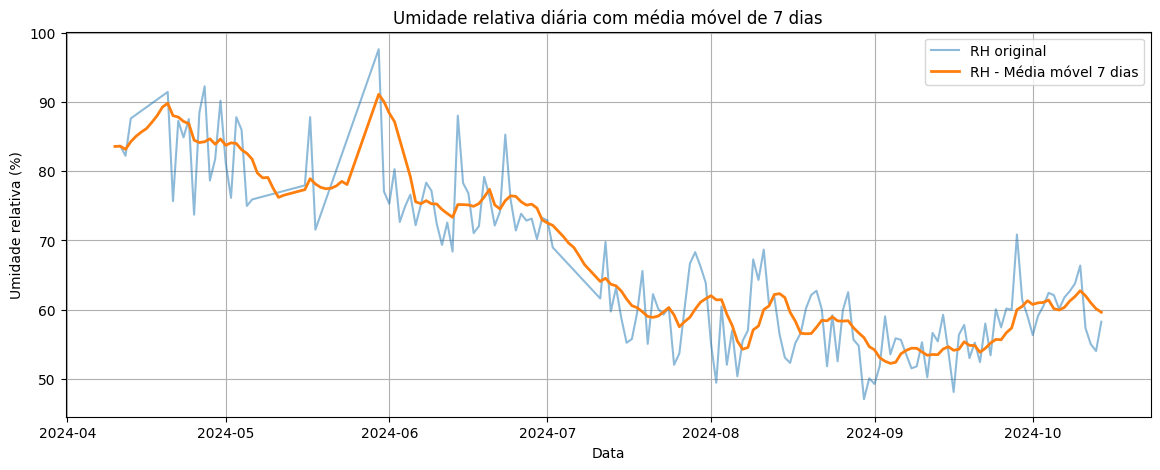

In [40]:
plt.figure(figsize=(14, 5))
plt.plot(df_diario['GHI'], label='GHI original', alpha=0.5)
plt.plot(df_diario['GHI_mm7'], label='GHI - Média móvel 7 dias', linewidth=2)
plt.title('GHI diária com média móvel de 7 dias')
plt.xlabel('Data')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_diario['TAMB'], label='TAMB original', alpha=0.5)
plt.plot(df_diario['TAMB_mm7'], label='TAMB - Média móvel 7 dias', linewidth=2)
plt.title('Temperatura diária com média móvel de 7 dias')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_diario['RH'], label='RH original', alpha=0.5)
plt.plot(df_diario['RH_mm7'], label='RH - Média móvel 7 dias', linewidth=2)
plt.title('Umidade relativa diária com média móvel de 7 dias')
plt.xlabel('Data')
plt.ylabel('Umidade relativa (%)')
plt.legend()
plt.grid()
plt.show()

* Vamos ver como as médias móveis, em uma janela de 30 dias, se comporta: 

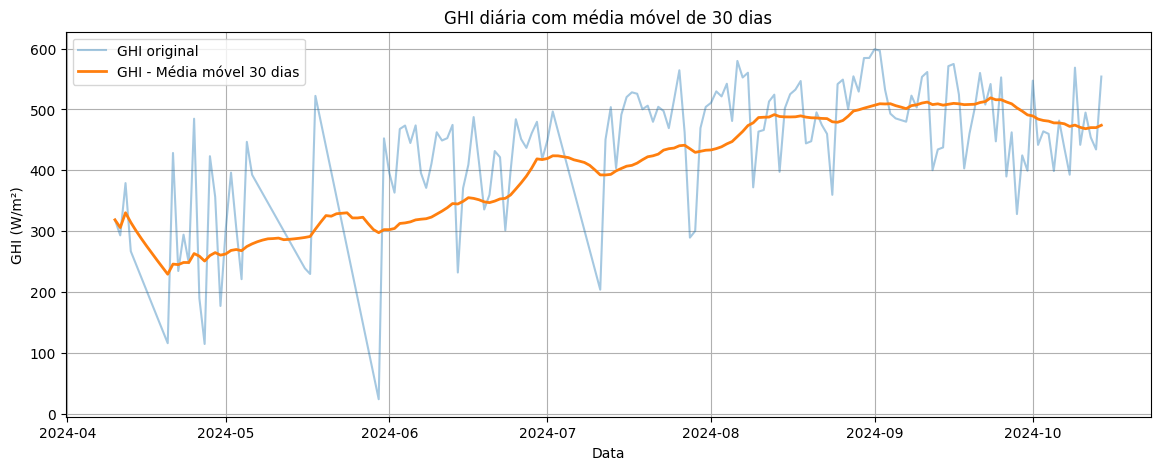

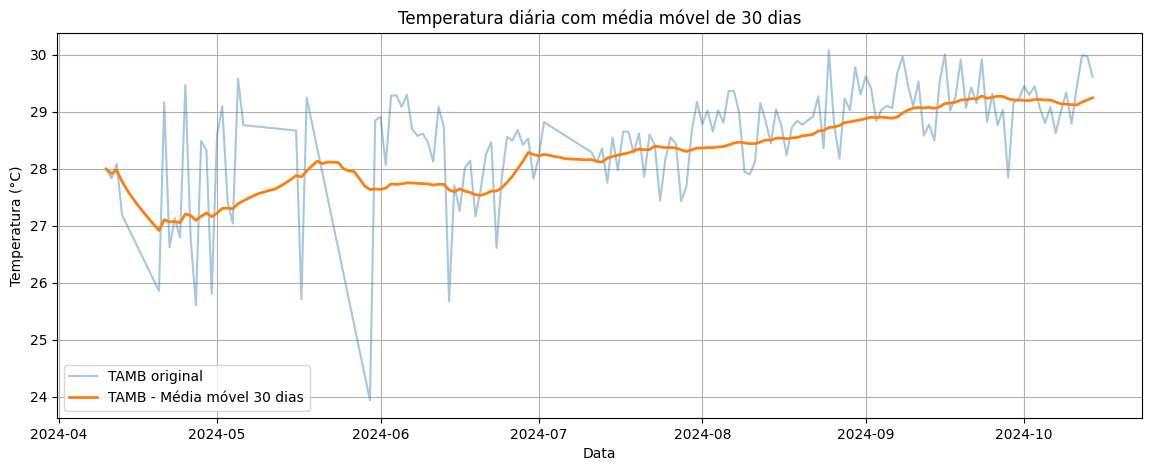

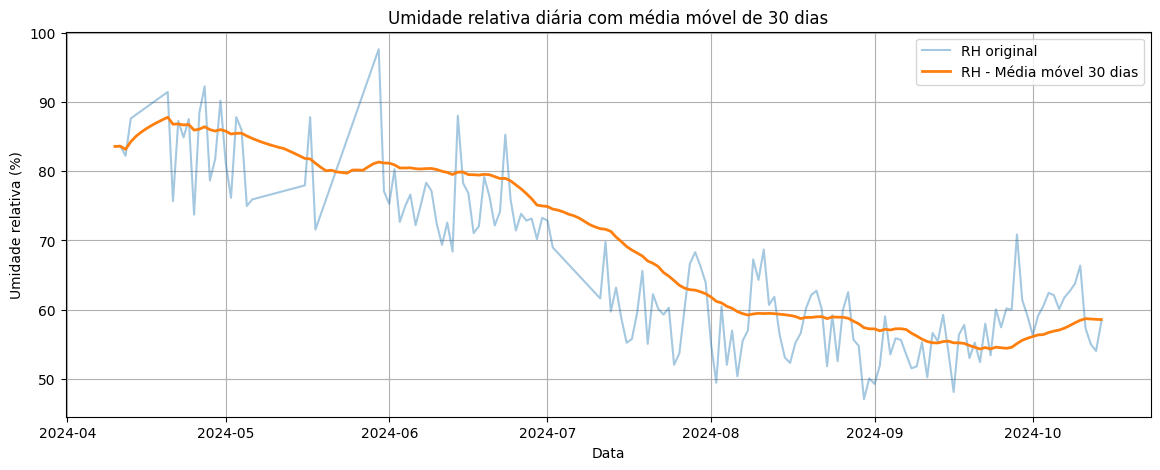

In [41]:
plt.figure(figsize=(14, 5))
plt.plot(df_diario['GHI'], label='GHI original', alpha=0.4)
plt.plot(df_diario['GHI_mm30'], label='GHI - Média móvel 30 dias', linewidth=2)
plt.title('GHI diária com média móvel de 30 dias')
plt.xlabel('Data')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_diario['TAMB'], label='TAMB original', alpha=0.4)
plt.plot(df_diario['TAMB_mm30'], label='TAMB - Média móvel 30 dias', linewidth=2)
plt.title('Temperatura diária com média móvel de 30 dias')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(df_diario['RH'], label='RH original', alpha=0.4)
plt.plot(df_diario['RH_mm30'], label='RH - Média móvel 30 dias', linewidth=2)
plt.title('Umidade relativa diária com média móvel de 30 dias')
plt.xlabel('Data')
plt.ylabel('Umidade relativa (%)')
plt.legend()
plt.grid()
plt.show()


# Previsão da irradiação solar para os próximos dias:

* Previsão para os próximos 3 meses:

18:50:57 - cmdstanpy - INFO - Chain [1] start processing


18:50:57 - cmdstanpy - INFO - Chain [1] done processing


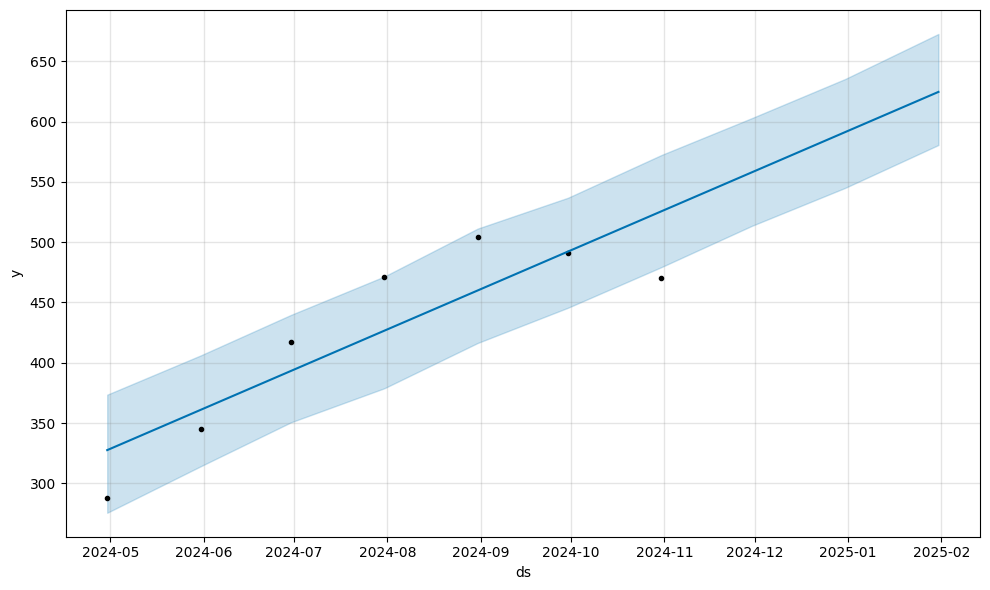

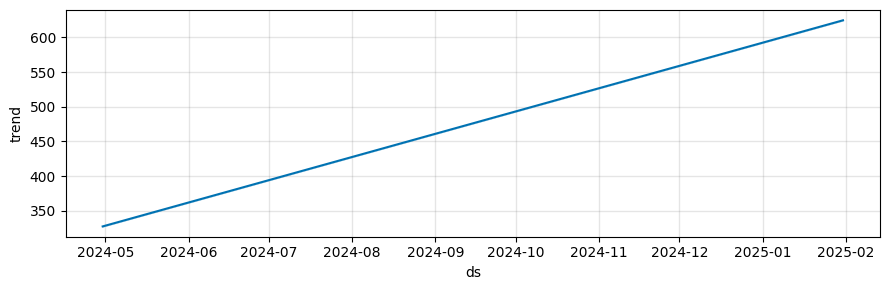

In [49]:
df_mensal_prophet = df_mensal[['GHI']].reset_index()
df_mensal_prophet.columns = ['ds', 'y']

m = Prophet()
m.fit(df_mensal_prophet)

futuro = m.make_future_dataframe(periods=3, freq='ME')

forecast = m.predict(futuro)

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

* Agora vamos buscar ver a previsão para os próximos 30 dias:

18:59:06 - cmdstanpy - INFO - Chain [1] start processing
18:59:07 - cmdstanpy - INFO - Chain [1] done processing


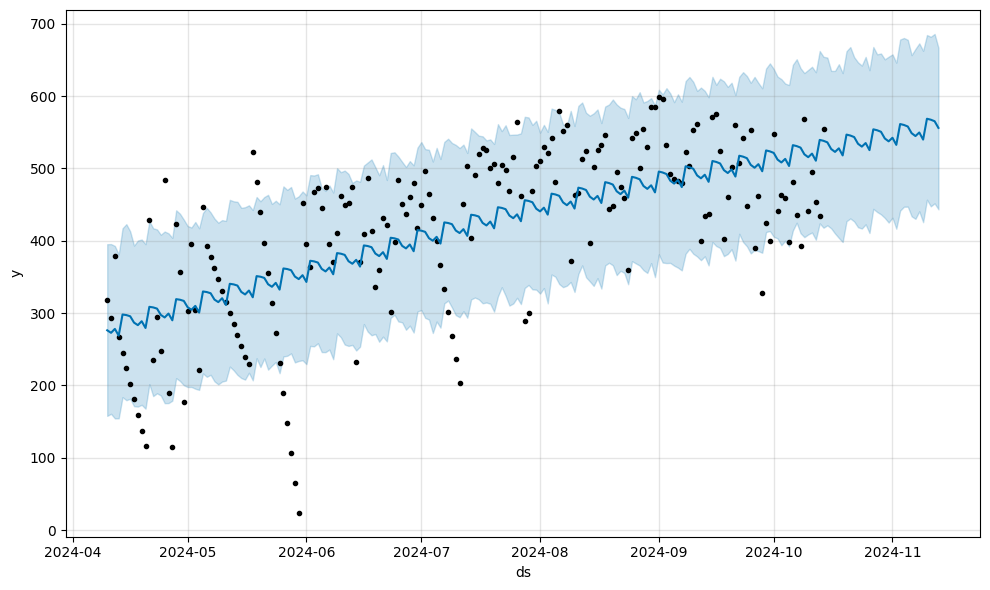

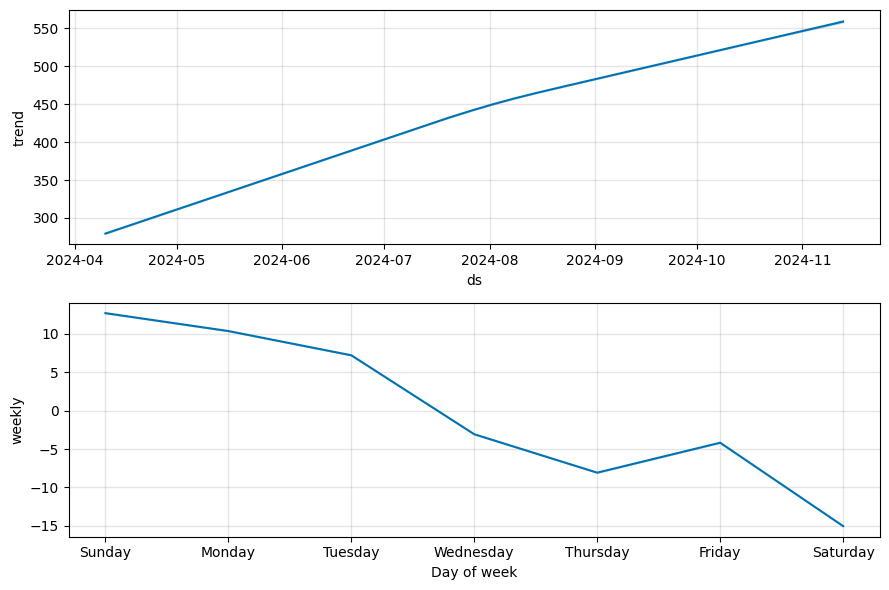

In [50]:
df_diario_prophet = df_diario[['GHI']].reset_index()
df_diario_prophet.columns = ['ds', 'y']

m_diario = Prophet()
m_diario.fit(df_diario_prophet)

futuro_diario = m_diario.make_future_dataframe(periods=30, freq='D')

forecast_diario = m_diario.predict(futuro_diario)

fig1_diario = m_diario.plot(forecast_diario)
fig2_diario = m_diario.plot_components(forecast_diario)
plt.show()

# Validação do modelo:

* Validação do modelo mensal:

19:14:29 - cmdstanpy - INFO - Chain [1] start processing


19:14:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE Mensal (3 meses): 14.19%


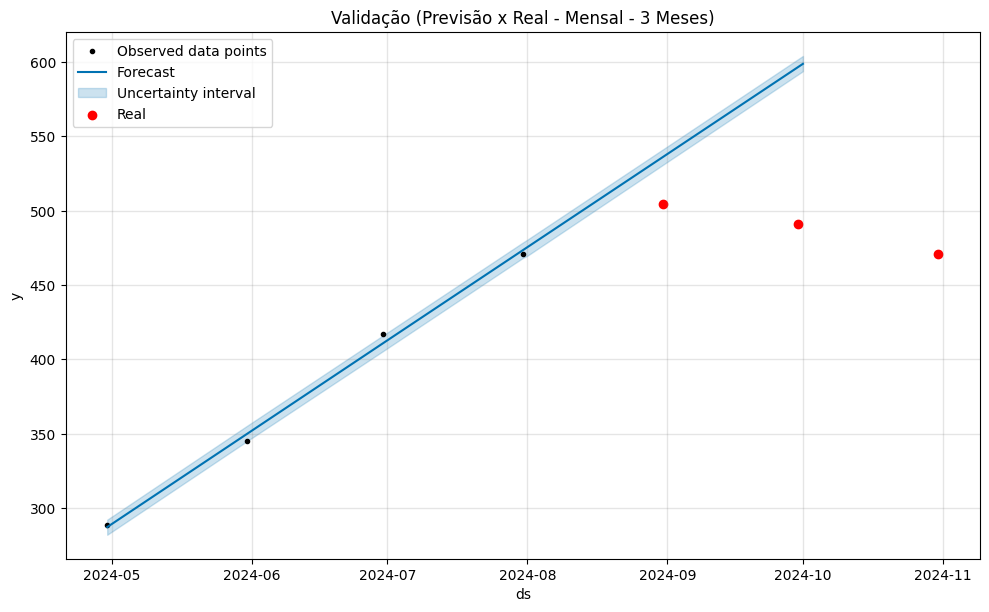

In [56]:
# Separar treino e teste (últimos 3 meses para teste)
treino_v2 = df_mensal_prophet.iloc[:-3]
teste_v2 = df_mensal_prophet.iloc[-3:]

# Treinar
modelo_v2 = Prophet()
modelo_v2.fit(treino_v2)

# Criar datas futuras para 3 meses (igual ao tamanho do teste)
futuro_v2 = modelo_v2.make_future_dataframe(periods=3, freq='MS')
previsao_v2 = modelo_v2.predict(futuro_v2)

# Comparar previsões com valores reais
# Ajustar as datas do teste para o início do mês
teste_v2_index = teste_v2['ds'].dt.to_period('M').dt.to_timestamp()
previstos = previsao_v2[['ds', 'yhat']].set_index('ds').loc[teste_v2_index]

# Calcular MAPE
mape = mean_absolute_percentage_error(teste_v2['y'], previstos['yhat']) * 100
print(f"MAPE Mensal (3 meses): {mape:.2f}%")

# Plot
fig = modelo_v2.plot(previsao_v2)
plt.scatter(teste_v2['ds'], teste_v2['y'], color='red', label='Real')
plt.title('Validação (Previsão x Real - Mensal - 3 Meses)')
plt.legend()
plt.show()


* Validação do modelo diário:

19:15:39 - cmdstanpy - INFO - Chain [1] start processing
19:15:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE Diário (30 dias): 23.81%


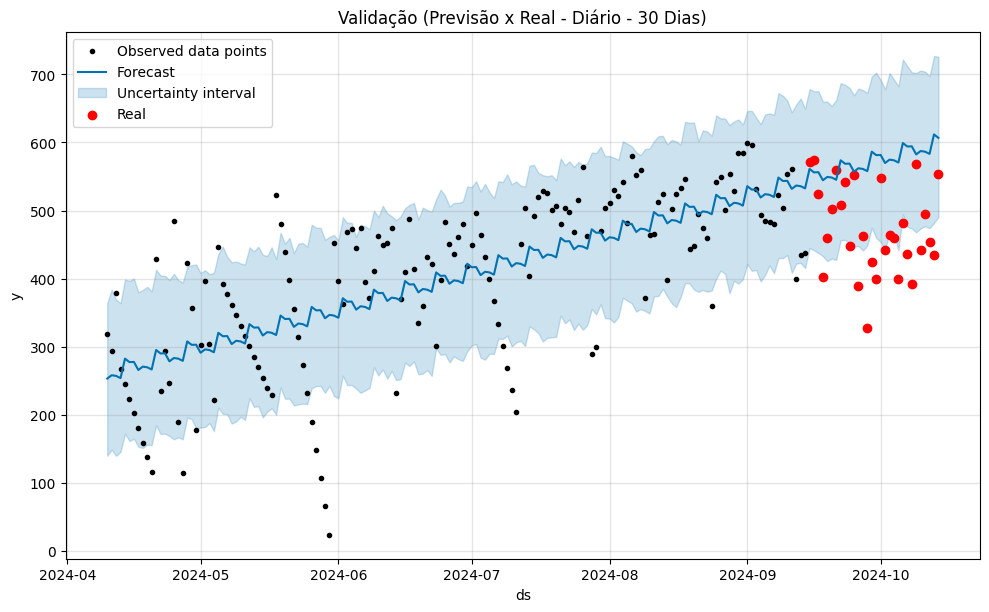

In [57]:
# Separar treino e teste (últimos 30 dias para teste)
treino_diario = df_diario_prophet.iloc[:-30]
teste_diario = df_diario_prophet.iloc[-30:]

# Treinar
modelo_diario = Prophet()
modelo_diario.fit(treino_diario)

# Criar datas futuras para 30 dias (igual ao teste)
futuro_diario = modelo_diario.make_future_dataframe(periods=30, freq='D')
previsao_diario = modelo_diario.predict(futuro_diario)

# Comparar previsões com valores reais
# As datas já estão no formato diário
teste_diario_index = teste_diario['ds']
previstos_diario = previsao_diario[['ds', 'yhat']].set_index('ds').loc[teste_diario_index]

# Calcular MAPE
mape_diario = mean_absolute_percentage_error(teste_diario['y'], previstos_diario['yhat']) * 100
print(f"MAPE Diário (30 dias): {mape_diario:.2f}%")

# Plot
fig = modelo_diario.plot(previsao_diario)
plt.scatter(teste_diario['ds'], teste_diario['y'], color='red', label='Real')
plt.title('Validação (Previsão x Real - Diário - 30 Dias)')
plt.legend()
plt.show()